In [37]:
pip install fastdtw

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3586 sha256=99f83b7a6c29fa7fefc2b496fe27c3947bf24580ae9a902a821557984ec6ebe5
  Stored in directory: c:\users\alex\appdata\local\pip\cache\wheels\5c\8a\f6\fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode, ks_2samp
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
params = (10., 28., 8/3)

x = get_data(*params)
points_number = x.shape[0]

In [4]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

step = 50 # right shift value
M = 20 # iterations number

predicted_points_number = 50

In [5]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [6]:
# Compute motives for train_data vector based on train_points number form point start

def fit(train_data, train_points_number, start, current_iter=1, max_iter=1):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration {current_iter}/{max_iter}", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [7]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [8]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict_with_demon(train_data, motives_list, begin, predicted_points_number, max_dist=0.05, max_mape=0.05):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
  for T in tqdm(range(begin, begin + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      # for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
      for i in range(patterns.shape[0]):
          vec = x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]]
          for motive in motives_list:
            normalized_predicted = norm(motive[i][:, :-1] - vec)
            St.extend(motive[i][(normalized_predicted < max_dist), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[begin : begin + predicted_points_number]

In [9]:
def calculate(train_points_number, begin, steps=M):
    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    motives_list = []

    for i in tqdm(range(steps), "Overall iterations loop"):
        start = begin + step * i
        motives = fit(x, train_points_number, start, current_iter=i + 1, max_iter=steps)
        motives_list.append(motives)

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, [motives], start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(steps):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= steps
    unpredicted_points /= steps

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points, motives_list

In [10]:
def calculate_mixed(train_points_number, begin, y_params, steps=M):
    data = [x]
    for param in y_params:
        data.append(get_data(*param))

    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    for i in tqdm(range(steps), "Overall iterations loop"):
        start = begin + step * i

        motives_list = [fit(arr, train_points_number, start, current_iter=i + 1, max_iter=M) for arr in data]

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, motives_list, start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(steps):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= steps
    unpredicted_points /= steps

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points

In [11]:
def plots(train_points_number, data):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series + alike series, train_size={train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(data[2])

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(data[3])

    plt.show()

In [12]:
train_points_number = 1000
begin = 0

In [14]:
# def metrics(params):
#     y = get_data(*params)
#     c = []
#     e = []
#     for _ in range(M):
#         cc, ee = ordpy.complexity_entropy(y, dx=5)
#         c.append(cc)
#         e.append(ee)
#     colm = np.mean([ks_2samp(x[begin + step * j: begin + step * j + train_points_number], y[begin + step * j: begin + step * j + train_points_number])[0] for j in range(M)])
#     return np.mean(np.array(c)), np.mean(np.array(e)), colm

Predictions without mixing

10 steps

In [ ]:
data00 = calculate(train_points_number, begin, steps=10)

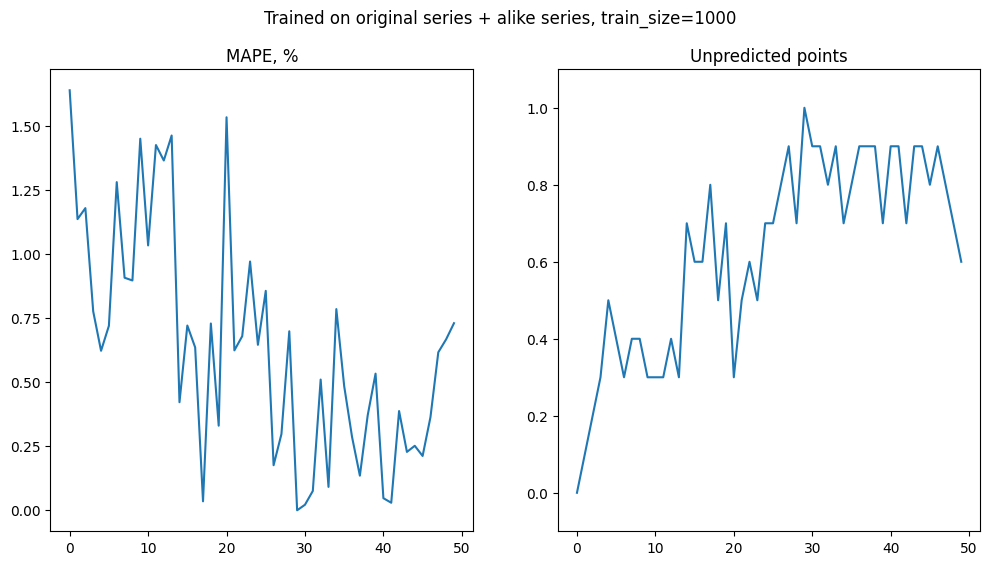

In [15]:
plots(train_points_number, data00)

20 steps

In [ ]:
data01 = calculate(train_points_number, begin, steps=20)

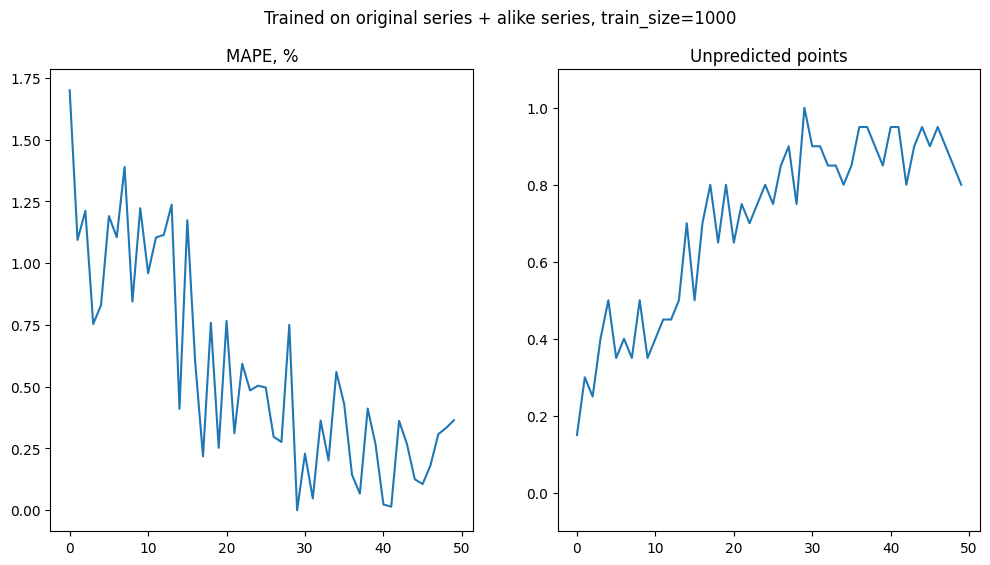

In [17]:
plots(train_points_number, data01)

In [24]:
print(np.mean(data01[3]))

0.703


50 steps

In [ ]:
data02 = calculate(train_points_number, begin, steps=50)

In [ ]:
plots(train_points_number, data02)

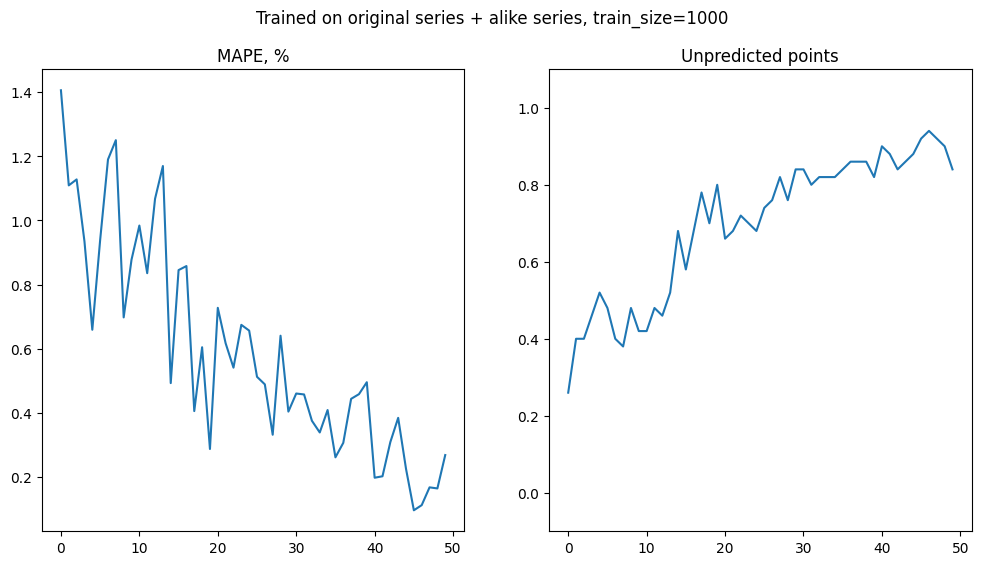

Analyzing series

In [18]:
def dtw_distance(series1, series2):
    series1 = np.array(series1).reshape(-1, 1)
    series2 = np.array(series2).reshape(-1, 1)
    distance, _ = fastdtw(series1, series2, dist=euclidean)
    return distance

In [21]:
y = get_data(params[0] * 0.99, params[1], params[2])

print(dtw_distance(x[:1000+50*20], y[:1000+50*20]))

210.90454382497813


In [ ]:
s = []

for p1 in tqdm(np.linspace(0.98, 1.02, 5), desc="Outer loop"):
    for p2 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner loop", leave=False):
        for p3 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner inner loop", leave=False):
            y = get_data(params[0] * p1, params[1] * p2, params[2] * p3)
            dst = dtw_distance(x[:train_points_number + step * M], y[:train_points_number + step * M])
            s.append([dst, p1, p2, p3])
            # metrics = []
            # for j in range(M):
            #     left = begin + step * j
            #     right = left + train_points_number
            #     y = get_data(params[0] * p1, params[1] * p2, params[2] * p3)
            #     metrics.append(dtw_distance(x[left:right], y[left:right]))
            # s.append([np.mean(metrics), p1, p2, p3])

In [27]:
ss = sorted(s)

In [28]:
print(*ss[:10], sep='\n')

[0.0, np.float64(1.0), np.float64(1.0), np.float64(1.0)]
[159.0510284045066, np.float64(1.01), np.float64(0.98), np.float64(1.0)]
[161.93067824077812, np.float64(0.99), np.float64(1.02), np.float64(0.98)]
[172.71137515451554, np.float64(0.98), np.float64(0.99), np.float64(1.01)]
[179.5442352918459, np.float64(0.99), np.float64(1.01), np.float64(1.02)]
[179.8664868637718, np.float64(1.0), np.float64(0.99), np.float64(0.98)]
[181.4987823535307, np.float64(1.01), np.float64(1.02), np.float64(1.0)]
[183.80945918503346, np.float64(1.0), np.float64(0.98), np.float64(0.99)]
[189.36626582139817, np.float64(1.01), np.float64(1.0), np.float64(1.0)]
[189.54990940444605, np.float64(0.99), np.float64(1.0), np.float64(0.98)]


Mixing 1

In [ ]:
mat1 = np.array([
    [1.01, 0.98, 1.]
])
data1 = calculate_mixed(train_points_number, begin, mat1 * params)

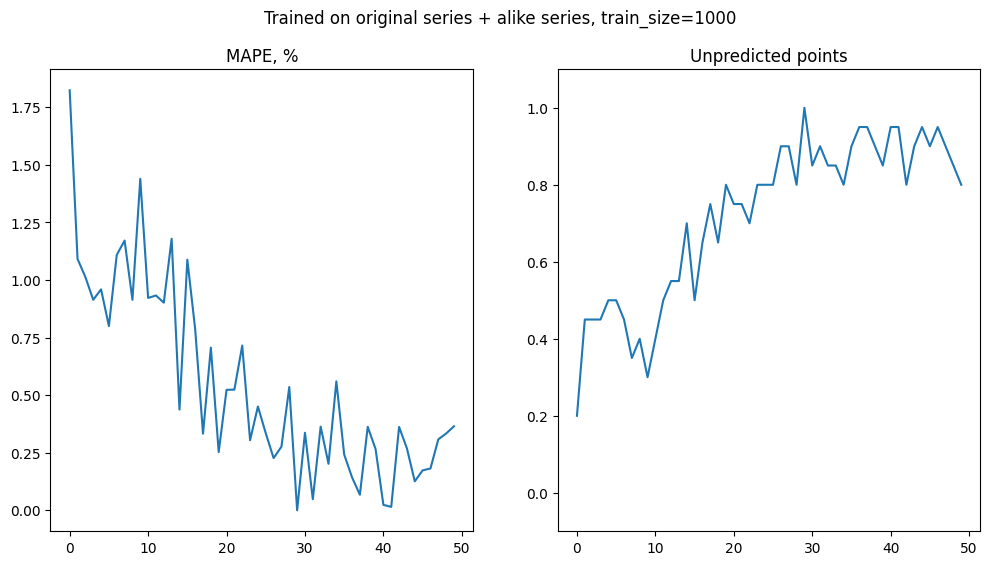

In [20]:
plots(train_points_number, data1)

In [21]:
print(np.mean(data1[3]))

0.721


Mixing 2

In [ ]:
mat2 = np.array([
    [0.99, 1.02, 0.98]
])
data2 = calculate_mixed(train_points_number, begin, mat2 * params)

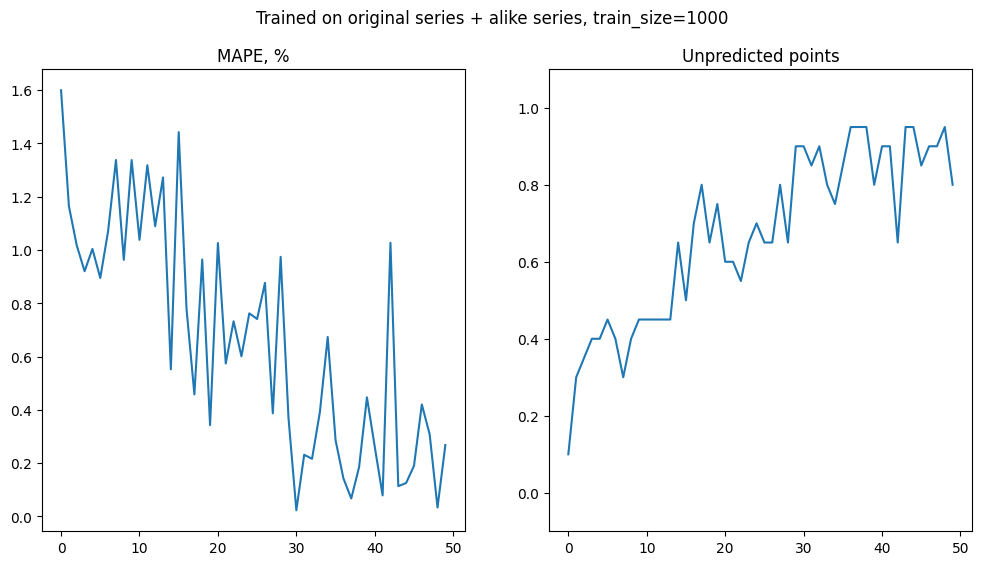

In [23]:
plots(train_points_number, data2)

In [24]:
print(np.mean(data2[3]))

0.672


Mixing 3

In [ ]:
mat3 = np.array([
    [0.98, 0.99, 1.01]
])
data3 = calculate_mixed(train_points_number, begin, mat3 * params)

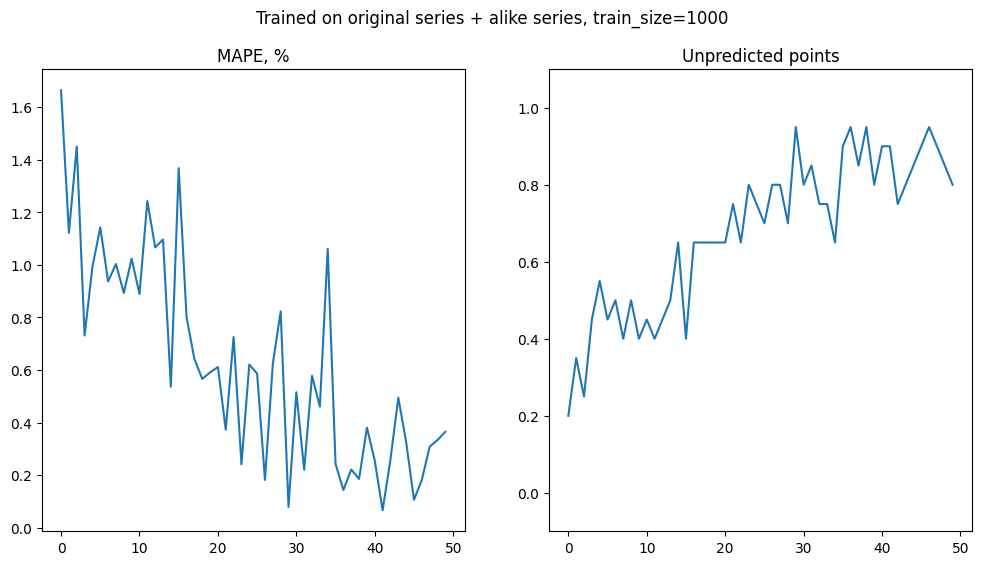

In [26]:
plots(train_points_number, data3)

In [27]:
print(np.mean(data3[3]))

0.6779999999999999


Mixing 4

In [ ]:
mat4 = np.array([
    [0.99, 1.01, 1.02]
])
data4 = calculate_mixed(train_points_number, begin, mat4 * params)

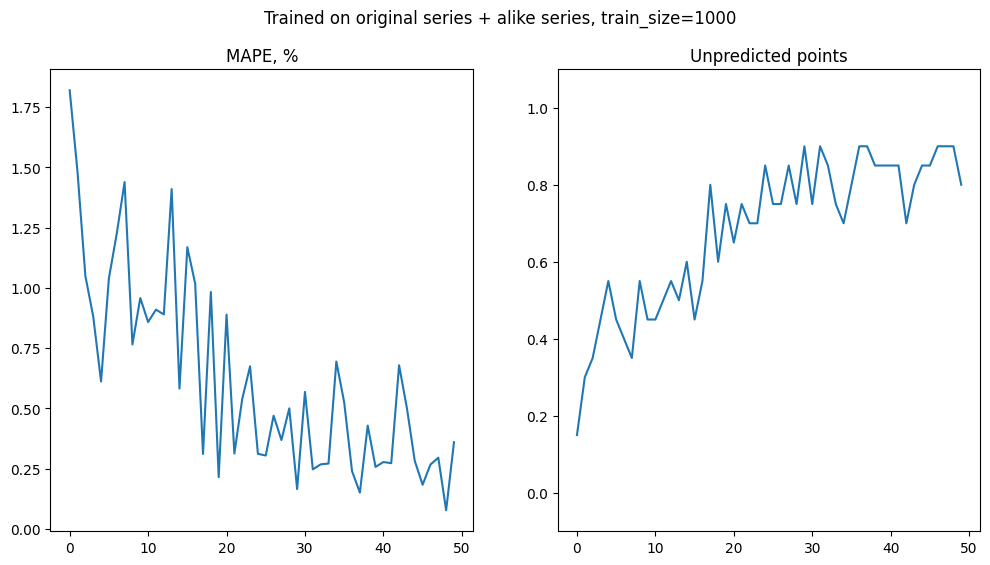

In [29]:
plots(train_points_number, data4)

In [30]:
print(np.mean(data3[3]))

0.6779999999999999


Mixing 5

In [ ]:
mat5 = np.array([
    [1., 0.99, 0.98]
])
data5 = calculate_mixed(train_points_number, begin, mat5 * params)

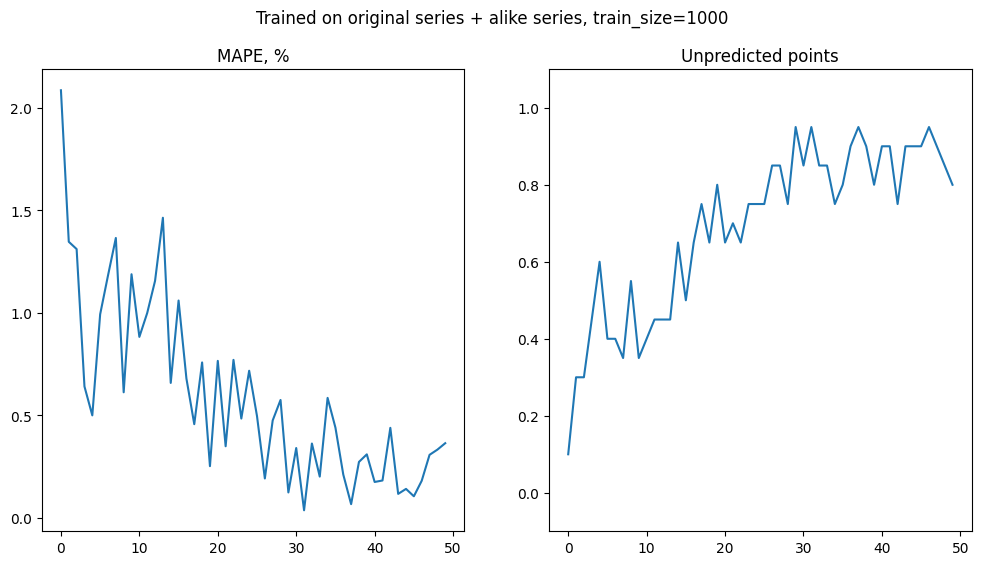

In [32]:
plots(train_points_number, data5)

In [33]:
print(np.mean(data5[3]))

0.691


Mixing 6

In [ ]:
mat6 = np.array([
    [0.99, 1.02, 0.98],
    [0.98, 0.99, 1.01]
])
data6 = calculate_mixed(train_points_number, begin, mat6 * params)

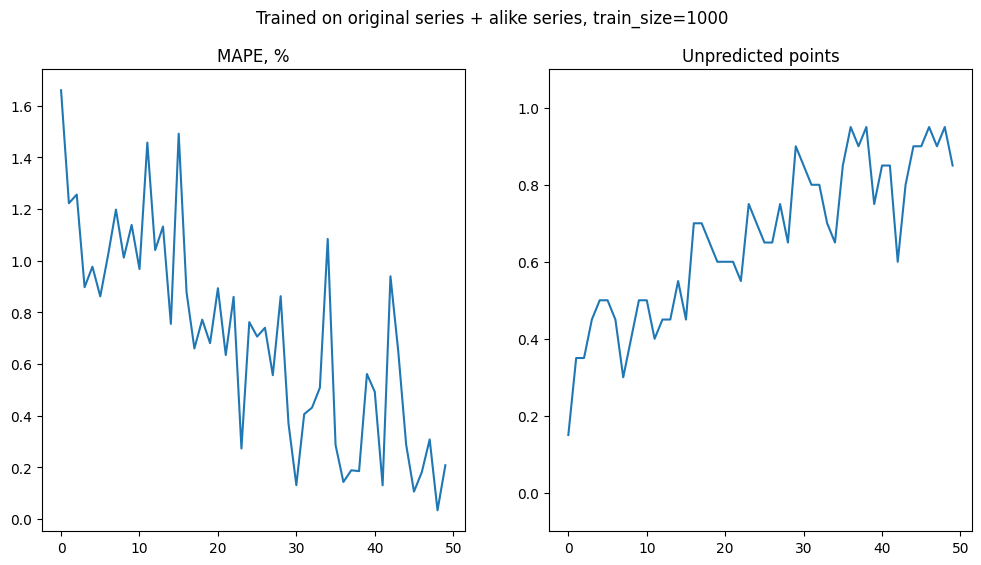

In [30]:
plots(train_points_number, data6)

In [31]:
print(np.mean(data6[3]))

0.659


Mixing 7

In [ ]:
mat7 = np.array([
    [0.99, 1.02, 0.98],
    [0.98, 0.99, 1.01],
    [0.99, 1.01, 1.02]
])
data7 = calculate_mixed(train_points_number, begin, mat7 * params)

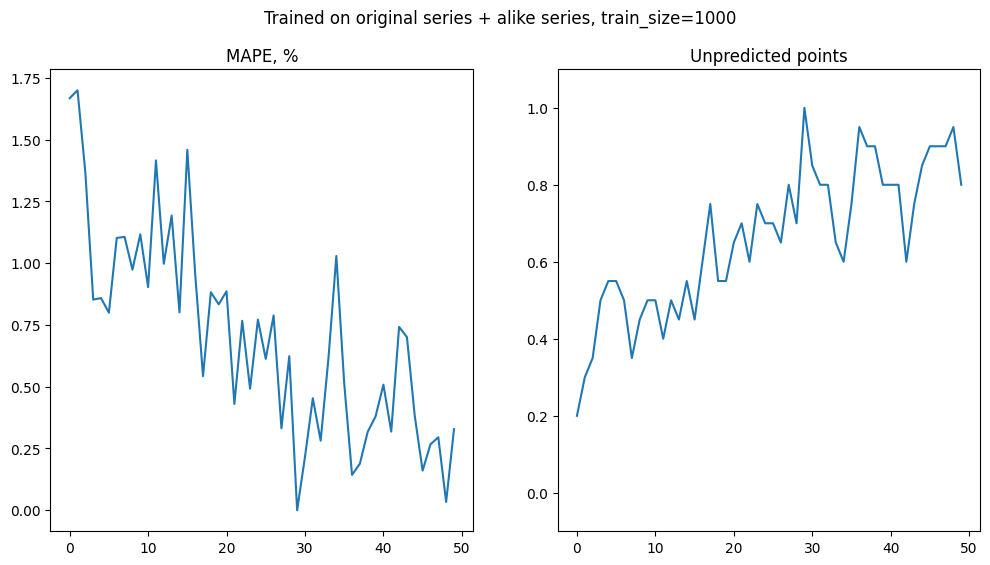

In [33]:
plots(train_points_number, data7)

In [34]:
print(np.mean(data7[3]))

0.6609999999999999


Mixing 8

In [ ]:
mat8 = np.array([
    [1.01, 1.02, 1.]
])
data8 = calculate_mixed(train_points_number, begin, mat8 * params)

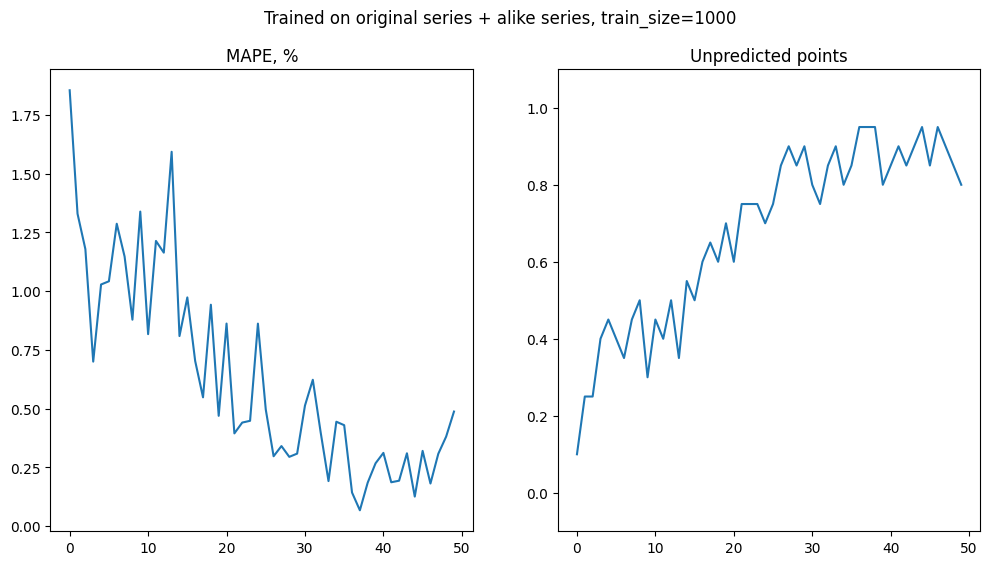

In [36]:
plots(train_points_number, data8)

In [37]:
print(np.mean(data8[3]))

0.6789999999999999


Mixing 9

In [ ]:
mat9 = np.array([
    [1., 0.98, 0.99]
])
data9 = calculate_mixed(train_points_number, begin, mat9 * params)

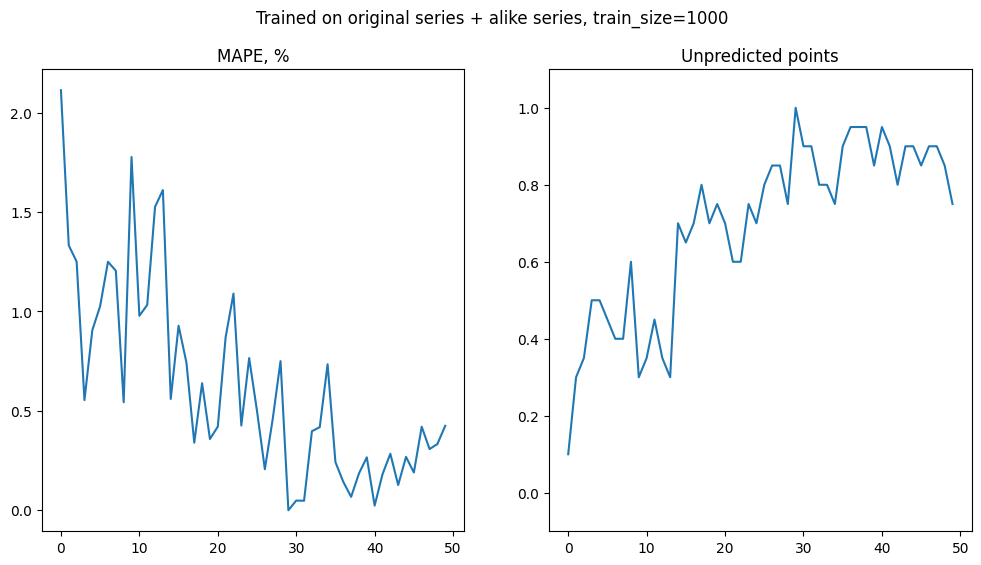

In [39]:
plots(train_points_number, data9)

In [40]:
print(np.mean(data9[3]))

0.6940000000000001


Mixing 10

In [ ]:
mat10 = np.array([
    [1.01, 1., 1.]
])
data10 = calculate_mixed(train_points_number, begin, mat10 * params)

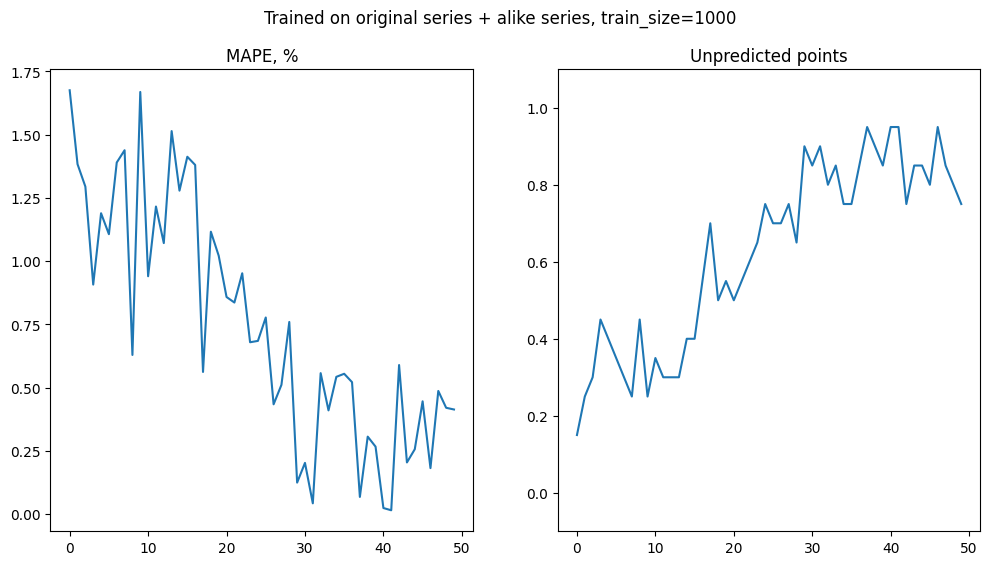

In [42]:
plots(train_points_number, data10)

In [43]:
print(np.mean(data10[3]))

0.6240000000000001


Mixing 11

In [ ]:
mat11 = np.array([
    [0.99, 1.02, 0.98],
    [1.01, 1., 1.]
])
data11 = calculate_mixed(train_points_number, begin, mat11 * params)

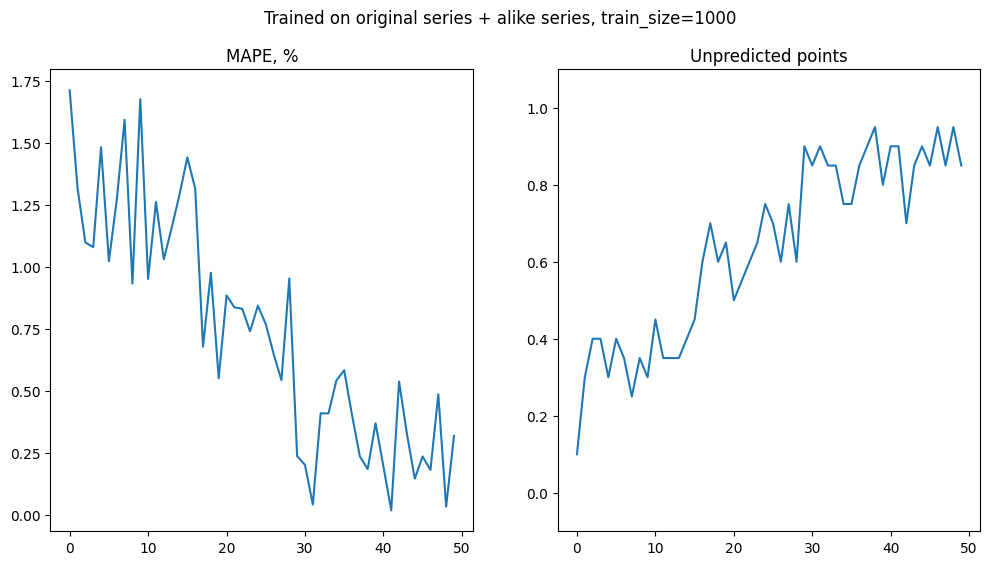

In [45]:
plots(train_points_number, data11)

In [46]:
print(np.mean(data11[3]))

0.636


Mixing 12

In [ ]:
mat12 = np.array([
    [0.99, 1.02, 0.98],
    [0.98, 0.99, 1.01],
    [1.01, 1., 1.]
])
data12 = calculate_mixed(train_points_number, begin, mat12 * params)

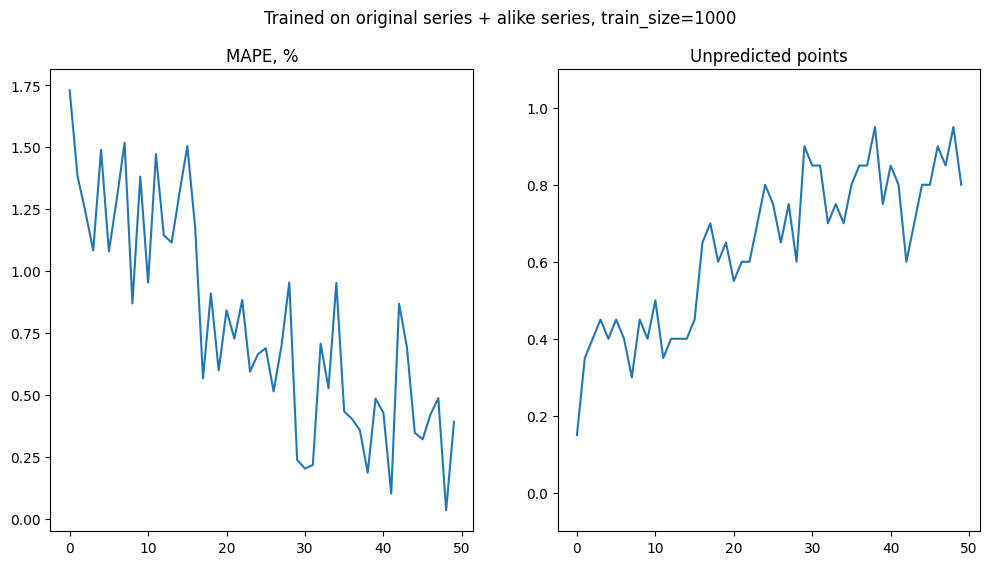

In [48]:
plots(train_points_number, data12)

In [49]:
print(np.mean(data12[3]))

0.637


Mixing 13

In [ ]:
mat13 = np.array([
    [0.99, 1., 1.]
])
data13 = calculate_mixed(train_points_number, begin, mat13 * params)

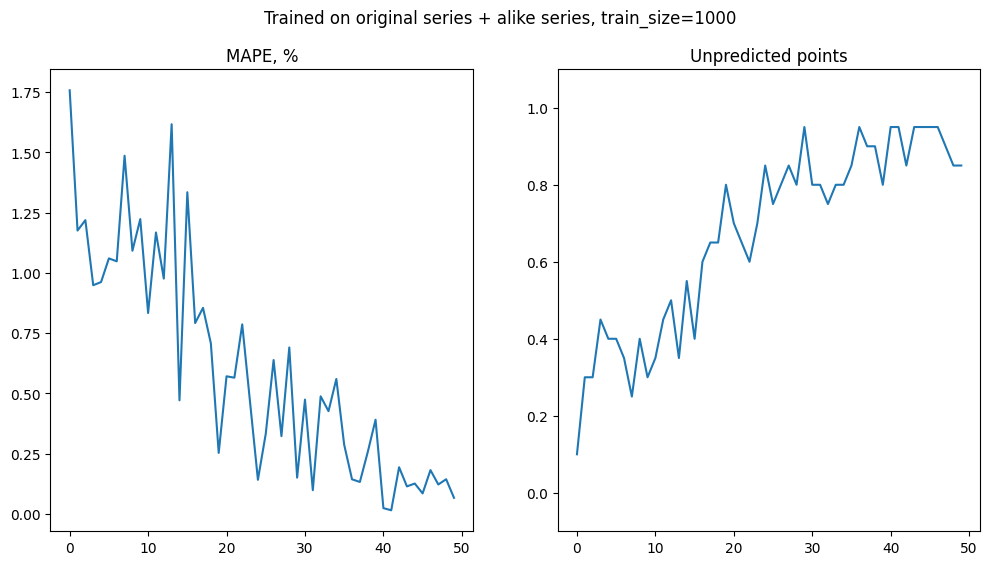

In [14]:
plots(train_points_number, data13)

In [15]:
print(np.mean(data13[3]))

0.674


Writing to csv

In [61]:
import csv

DATA = [data00, data01, data6, data7, data8, data9, data10, data11, data12]
with open('DATA/dtw.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i, data in enumerate(DATA):
        writer.writerow(list(map(str, data[2])))
        writer.writerow(list(map(str, data[3])))
        if i + 1 < len(DATA):
            writer.writerow("-" * 100)